# üìä NPL-Sentinel: An√°lise de Sentimento em Avalia√ß√µes de Produtos üì±

- #### Curso: P√≥s-Gradua√ß√£o em Deep Learning (CIn - UFPE)
- ##### Disciplina: Processamento de Linguagem Natural  
  - ##### Professor: Luciano Barbosa

- ##### üë• Grupo:
  - Paloma Corr√™a Alves (pca2@cin.ufpe.br)
  - Luciano Ayres Farias de Carvalho (lafc@cin.ufpe.br)

## üìñ Sobre o Projeto

### üîç Vis√£o Geral  
O **NPL-Sentinel** √© um projeto que explora **Processamento de Linguagem Natural (PLN)** para analisar sentimentos expressos em avalia√ß√µes de consumidores sobre um produto fict√≠cio: um **smartphone**. üì±‚ú®

### üéØ Objetivo  
Este projeto tem como **meta principal** identificar a polaridade dos sentimentos (üòä Positivo, üòê Neutro, üòû Negativo) contidos nas avalia√ß√µes dos consumidores. Al√©m disso:  
- **üìà Correlacionar** a polaridade dos sentimentos com as notas atribu√≠das pelos consumidores, validando a precis√£o do modelo.  
- **üîç Realizar an√°lises explorat√≥rias** para identificar padr√µes nas avalia√ß√µes, destacando os aspectos mais comentados em avalia√ß√µes positivas e negativas.  

### ü§ñ Modelos Utilizados  
üîπ **SVM + Bag of Words (BoW)**  
üîπ **SVM + Embeddings**  
üîπ **BERT**  
üîπ **In-Context Learning**: OpenAI  
üîπ **In-Content Learning**: Google Gemini  

### üìë Sobre os Dados  
Os dados utilizados foram **sinteticamente gerados** pelo modelo **ChatGPT-4 da OpenAI** e consistem em:  
- **üí¨ review:** Coment√°rio livre do consumidor sobre o produto.  
- **‚≠ê rating:** Nota (1 a 5) atribu√≠da pelo consumidor, indicando sua satisfa√ß√£o com o smartphone.  

### üí° Por que NPL-Sentinel?  
Porque a ideia √© ir al√©m da an√°lise b√°sica, atuando como um "sentinela" que monitora tend√™ncias, sentimentos e insights valiosos diretamente das opini√µes dos consumidores. üöÄ

# 1. Carregamento dos Dados

In [2]:
import pandas as pd

# URL do arquivo CSV remoto
url = "https://raw.githubusercontent.com/lucianoayres/npl-sentinel/refs/heads/main/data/reviews.csv"

# Carrega o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(url)

# Salva o DataFrame localmente no Google Colab
df.to_csv("reviews.csv", index=False)

# Exibe as primeiras linhas do DataFrame (opcional)
print(df.head())

                                              review  rating
0  O produto √© ok, nada demais. n√£o se destaca no...       3
1        Decepcionante, n√£o atendeu √†s expectativas.       1
2  N√£o tenho muito o que comentar, cumpre o que p...       2
3        Decepcionante, n√£o funcionou como esperado.       2
4                   √â razo√°vel, n√£o √© nada especial.       2


In [3]:
# Imprime um describe detalhado, incluindo todas as colunas
print("\nDescribe detalhado dos dados:")
print(df.describe(include='all'))


Describe detalhado dos dados:
                                            review       rating
count                                         1195  1195.000000
unique                                        1107          NaN
top     Cumpre o que promete, mas nada al√©m disso.          NaN
freq                                             3          NaN
mean                                           NaN     3.531381
std                                            NaN     1.438165
min                                            NaN     1.000000
25%                                            NaN     2.000000
50%                                            NaN     4.000000
75%                                            NaN     5.000000
max                                            NaN     5.000000


# 2. Pr√©-processamento dos Dados

Uso do `nltk` para tokeniza√ß√£o, remo√ß√£o de stopwords e outras t√©cnicas de limpeza.

In [4]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

# Faz o download das stopwords
nltk.download("stopwords")
stop_words = stopwords.words("portuguese")

# Pr√©-processa o texto das avalia√ß√µes
def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char.isalnum() or char.isspace()])
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df["clean_review"] = df["review"].apply(preprocess_text)

# Verifica e remove linhas com review ou rating vazio
empty_reviews = df["review"].isnull() | (df["review"].str.strip() == "")
empty_ratings = df["rating"].isnull()
df = df[~(empty_reviews | empty_ratings)]

# Exibe a quantidade de reviews e ratings vazios removidos
print("\nItens Removidos:")
print("Reviews vazios:", df["review"].isnull().sum() + (df["review"].str.strip() == "").sum())
print("Ratings vazios:", df["rating"].isnull().sum())


Itens Removidos:
Reviews vazios: 0
Ratings vazios: 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string

# Faz o download das stopwords
nltk.download("stopwords")
stop_words = stopwords.words("portuguese")

# Fun√ß√£o para pr√©-processar o texto
def preprocess_text(text):
    text = text.lower()  # Converte para min√∫sculas
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove pontua√ß√£o
    text = "".join([char for char in text if char.isalnum() or char.isspace()])  # Remove caracteres n√£o alfanum√©ricos
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)  # Junta os tokens de volta em uma string

# Aplica a fun√ß√£o de pr√©-processamento √† coluna 'review'
df["clean_review"] = df["review"].apply(preprocess_text)

# Fun√ß√£o para converter notas em r√≥tulos de sentimento
def convert_to_sentiment(rating):
    if rating >= 4:
        return "positivo"
    elif rating <= 2:
        return "negativo"
    else:
        return "neutro"

# Aplica a fun√ß√£o de convers√£o √† coluna 'rating'
df["sentiment"] = df["rating"].apply(convert_to_sentiment)

# Verifica e remove linhas com review ou rating vazio
empty_reviews = df["review"].isnull() | (df["review"].str.strip() == "")
empty_ratings = df["rating"].isnull()
df = df[~(empty_reviews | empty_ratings)]

# Exibe a quantidade de reviews e ratings vazios removidos
print("\nItens Removidos:")
print("Reviews vazios:", df["review"].isnull().sum() + (df["review"].str.strip() == "").sum())
print("Ratings vazios:", df["rating"].isnull().sum())


Itens Removidos:
Reviews vazios: 0
Ratings vazios: 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. An√°lise Descritiva

## 3.1. Distribui√ß√£o das Notas (rating)

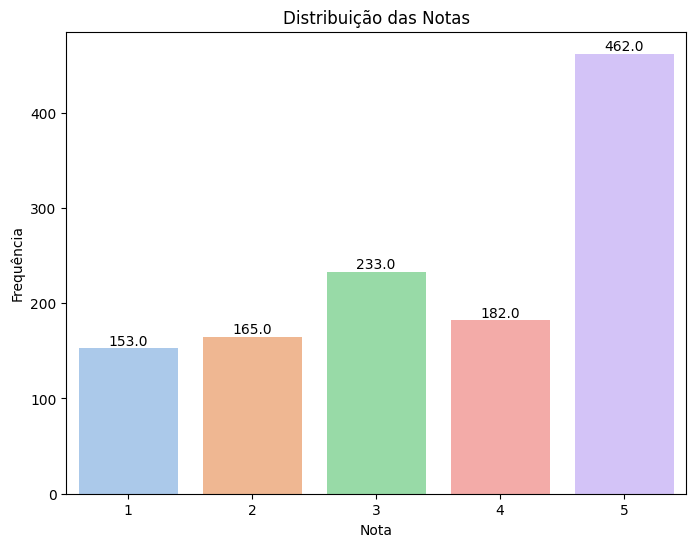

In [11]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# An√°lise da Distribui√ß√£o das Notas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='rating', data=df, hue='rating', palette='pastel', legend=False)  # Changes here

# Adiciona os totais em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribui√ß√£o das Notas')
plt.xlabel('Nota')
plt.ylabel('Frequ√™ncia')
plt.show()

### Resultados Totais da Distribui√ß√£o das Notas

In [10]:
# Imprime os totais para cada nota
print("\nResultados Totais da Distribui√ß√£o das Notas:")
rating_counts = df['rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"Nota {rating}: {count} avalia√ß√µes")


Resultados Totais da Distribui√ß√£o das Notas:
Nota 1: 153 avalia√ß√µes
Nota 2: 165 avalia√ß√µes
Nota 3: 233 avalia√ß√µes
Nota 4: 182 avalia√ß√µes
Nota 5: 462 avalia√ß√µes


## 3.2. Histograma do Comprimento das Avalia√ß√µes (review)


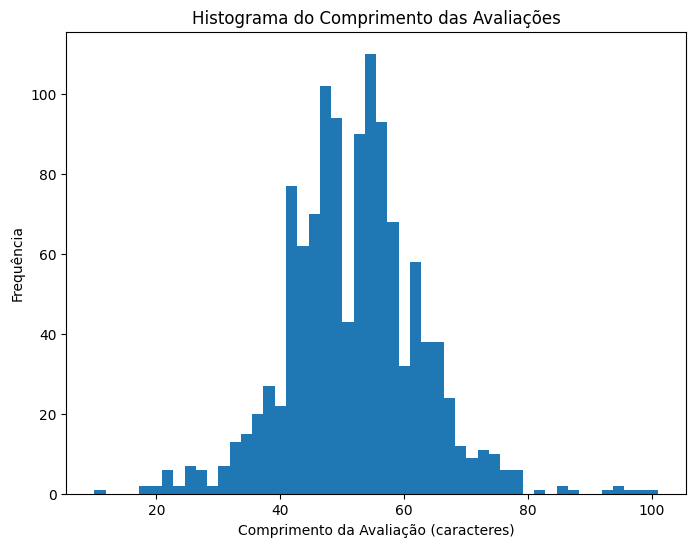

In [12]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['review'].str.len(), bins=50)
plt.title('Histograma do Comprimento das Avalia√ß√µes')
plt.xlabel('Comprimento da Avalia√ß√£o (caracteres)')
plt.ylabel('Frequ√™ncia')
plt.show()

### Estat√≠sticas do Comprimento das Avalia√ß√µes

In [13]:
import pandas as pd
import numpy as np

review_lengths = df['review'].str.len()
hist, bin_edges = np.histogram(review_lengths, bins=50) # Calculate hist and bin_edges

# Cria um DataFrame para estat√≠sticas resumidas
summary_data = {
    "M√©trica": ["Total de Avalia√ß√µes", "Comprimento M√©dio", "Comprimento M√≠nimo", "Comprimento M√°ximo", "Desvio Padr√£o"],
    "Valor": [
        len(review_lengths),
        f"{review_lengths.mean():.2f} caracteres",
        f"{review_lengths.min()} caracteres",
        f"{review_lengths.max()} caracteres",
        f"{review_lengths.std():.2f} caracteres",
    ],
}
summary_df = pd.DataFrame(summary_data)

# Cria um DataFrame para a distribui√ß√£o de comprimentos
distribution_data = {
    "Intervalo de Comprimento": [f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}" for i in range(len(hist))],
    "Frequ√™ncia (Avalia√ß√µes)": hist,
}
distribution_df = pd.DataFrame(distribution_data)

# Exibe as tabelas
print("Estat√≠sticas Resumidas:")
print(summary_df.to_string(index=False))  # index=False para ocultar os n√∫meros das linhas

print("\nDistribui√ß√£o de Comprimentos:")
print(distribution_df.to_string(index=False))

Estat√≠sticas Resumidas:
            M√©trica            Valor
Total de Avalia√ß√µes             1195
  Comprimento M√©dio 51.96 caracteres
 Comprimento M√≠nimo    10 caracteres
 Comprimento M√°ximo   101 caracteres
      Desvio Padr√£o 10.76 caracteres

Distribui√ß√£o de Comprimentos:
Intervalo de Comprimento  Frequ√™ncia (Avalia√ß√µes)
                   10-12                        1
                   12-14                        0
                   14-15                        0
                   15-17                        0
                   17-19                        2
                   19-21                        2
                   21-23                        6
                   23-25                        2
                   25-26                        7
                   26-28                        6
                   28-30                        2
                   30-32                        7
                   32-34                       13
          

## 3.3. Nuvem de Palavras


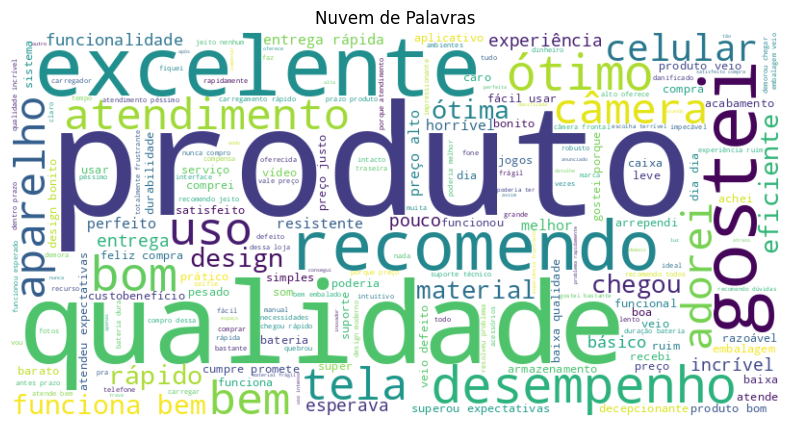

In [14]:
from wordcloud import WordCloud
text = ' '.join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras')
plt.show()

### Resultados para a Nuvem de Palavras

In [15]:
import pandas as pd

# Obter as palavras mais frequentes e suas frequ√™ncias
word_freq = wordcloud.words_

# Criar um DataFrame para armazenar as palavras e frequ√™ncias
top_words_df = pd.DataFrame(list(word_freq.items())[:10], columns=['Palavra', 'Frequ√™ncia'])

# Exibir o DataFrame como uma tabela
print("Top 10 palavras mais frequentes:")
print(top_words_df.to_string(index=False))

Top 10 palavras mais frequentes:
   Palavra  Frequ√™ncia
   produto    1.000000
 qualidade    0.471154
 excelente    0.403846
    gostei    0.350962
 recomendo    0.274038
desempenho    0.245192
     √≥timo    0.230769
       bom    0.225962
       uso    0.211538
       bem    0.206731


## 3.4 Frequ√™ncia das Entidades (review)


In [18]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import spacy

import plotly.express as px

# Carregamento do modelo de linguagem do spaCy
nlp = spacy.load('pt_core_news_md')

# Pr√©-processamento com spaCy
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return ' '.join(tokens)

df['clean_review'] = df['review'].astype(str).apply(preprocess)

# An√°lise de Entidades Nomeadas com spaCy
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'LOC', 'PRODUCT']]

df['entities'] = df['review'].astype(str).apply(extract_entities)

# Contagem das entidades mais frequentes
all_entities = [entity for sublist in df['entities'] for entity in sublist]
entity_freq = Counter(all_entities).most_common(20)

  Using cached https://github.com/explosion/spacy-models/releases/download/pt_core_news_md-3.7.0/pt_core_news_md-3.7.0-py3-none-any.whl (42.4 MB)
‚úî Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


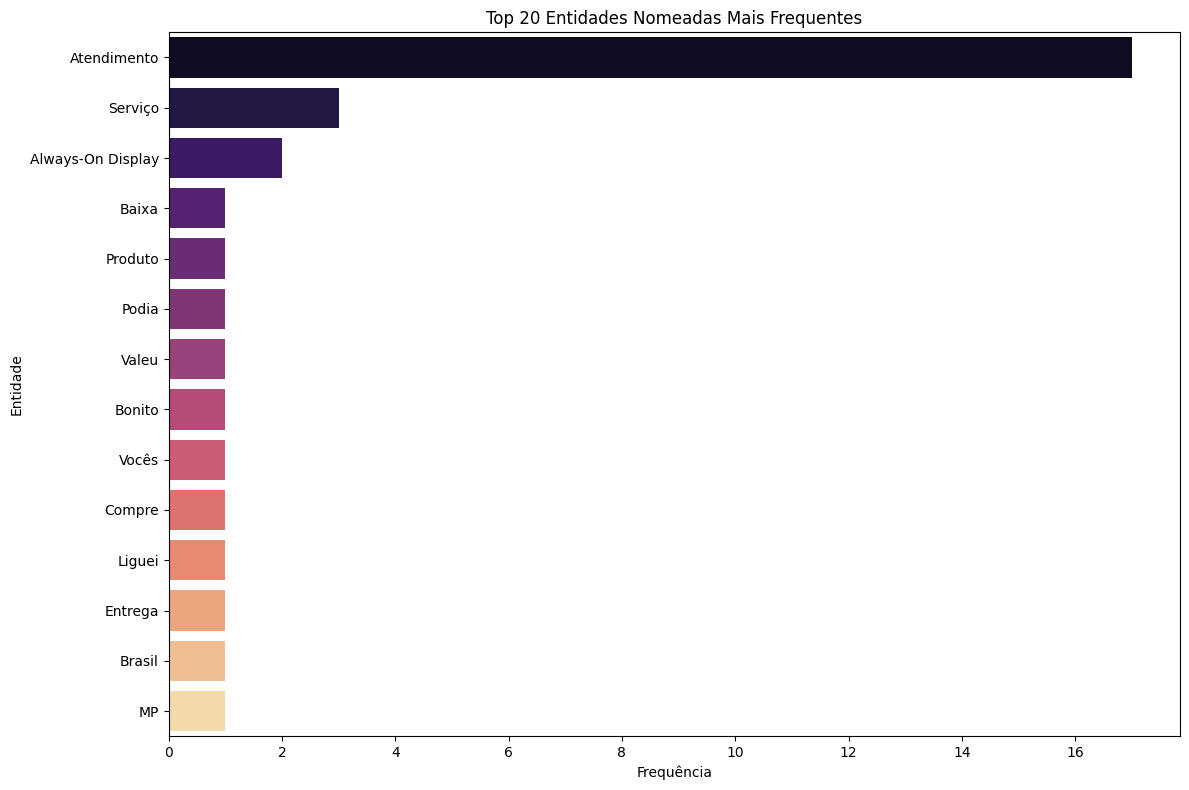

In [20]:
# Visualiza√ß√£o: Frequ√™ncia das Entidades
entities_df = pd.DataFrame(entity_freq, columns=['Entidade', 'Frequ√™ncia'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequ√™ncia', y='Entidade', data=entities_df, palette='magma', hue='Entidade', dodge=False)  # Modified line
plt.title('Top 20 Entidades Nomeadas Mais Frequentes')
plt.xlabel('Frequ√™ncia')
plt.ylabel('Entidade')
plt.tight_layout()
plt.show()

## 3.5 An√°lise de N-grams (Bigrams e Trigrams com TF-IDF)

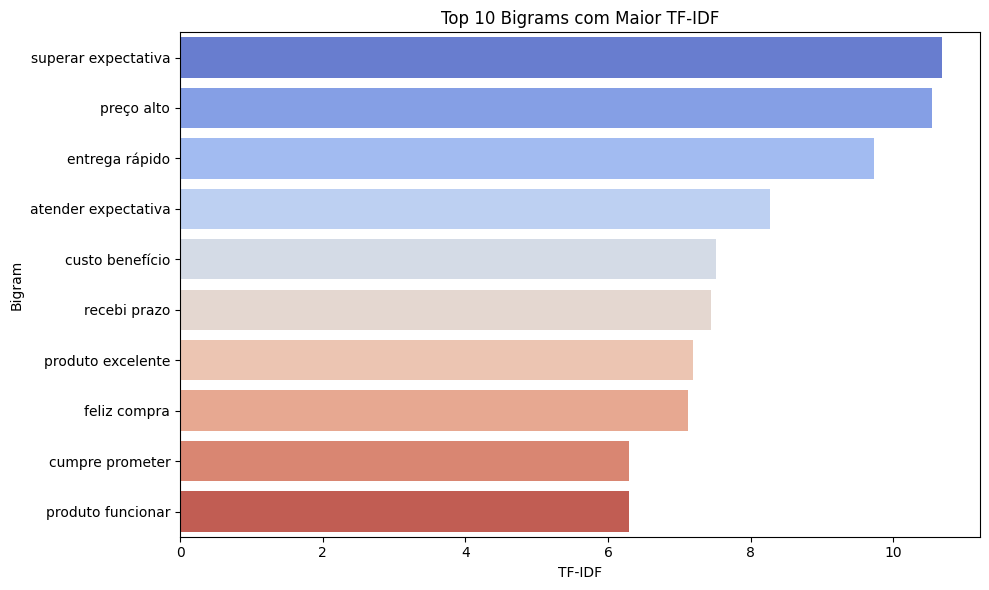

In [24]:
# An√°lise de N-grams Avan√ßada (Bigrams e Trigrams com TF-IDF)
def get_top_ngrams(corpus, n=None, top=None):
    vec = TfidfVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

top_bigrams = get_top_ngrams(df['clean_review'], n=2, top=10)
top_trigrams = get_top_ngrams(df['clean_review'], n=3, top=10)

# Visualiza√ß√£o de Bigrams
bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'TF-IDF'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Bigram', data=bigrams_df, hue='Bigram', palette='coolwarm', dodge=False, legend=False) # Modified line
plt.title('Top 10 Bigrams com Maior TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()

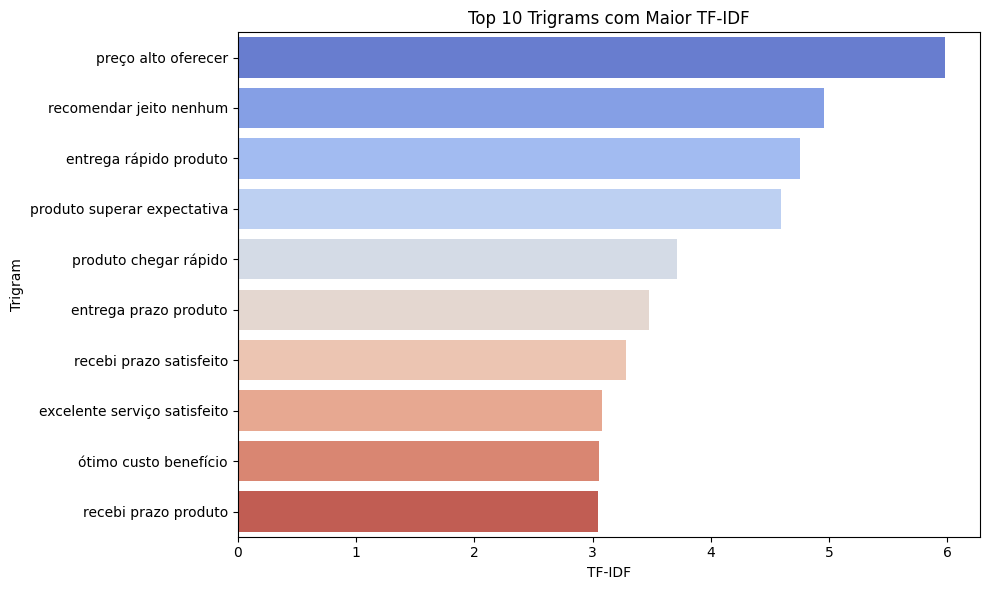

In [25]:
# Visualiza√ß√£o de Trigrams
trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'TF-IDF'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Trigram', data=trigrams_df, hue='Trigram', palette='coolwarm', dodge=False, legend=False)
plt.title('Top 10 Trigrams com Maior TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

## 3.6 An√°lise do Comprimento da Avalia√ß√£o vs. Nota com Regress√£o

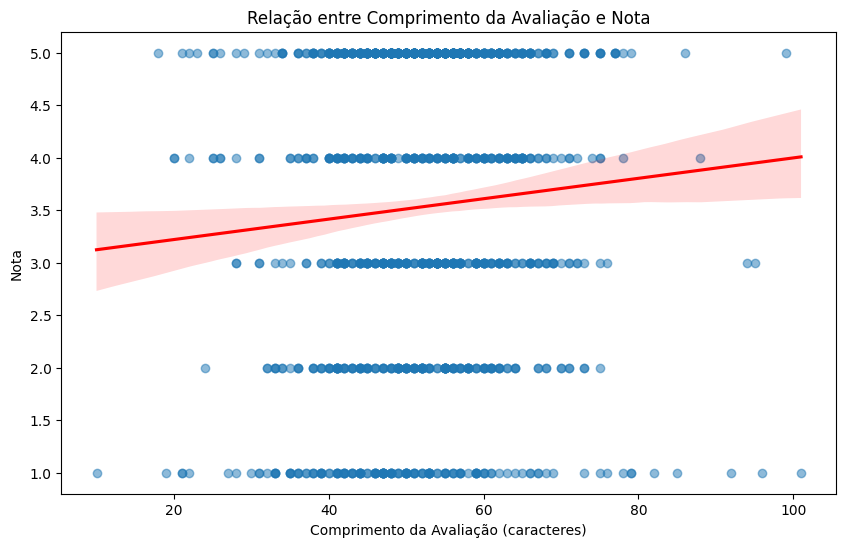

In [26]:
# An√°lise do Comprimento da Avalia√ß√£o vs. Nota com Regress√£o
df['review_length'] = df['review'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='rating', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Rela√ß√£o entre Comprimento da Avalia√ß√£o e Nota')
plt.xlabel('Comprimento da Avalia√ß√£o (caracteres)')
plt.ylabel('Nota')
plt.show()

### Correla√ß√£o entre Comprimento da Avalia√ß√£o e Nota

In [27]:
# Calcular e imprimir a correla√ß√£o
correlation = df['review_length'].corr(df['rating'])
print("-" * 50)
print(f"Coeficiente de correla√ß√£o de Pearson: {correlation:.2f}")
print("-" * 50)

--------------------------------------------------
Coeficiente de correla√ß√£o de Pearson: 0.07
--------------------------------------------------


# 4. Treinamento de Classificadores

## 4.1 SVM + Bag of Words (BoW)

In [28]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Divide o dataset
X_train, X_test, y_train, y_test = train_test_split(df["clean_review"], df["rating"], test_size=0.2, random_state=42)

# Pipeline para SVM com Bag of Words
pipeline_bow = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", SVC())
])

# Treinamento
pipeline_bow.fit(X_train, y_train)
y_pred_bow = pipeline_bow.predict(X_test)

### Avalia√ß√£o dos Resultados para o SVM + Bag of Words (BoW)

In [29]:
# Avalia√ß√£o
print("SVM + Bag of Words")
print(classification_report(y_test, y_pred_bow))

# Calcula a acur√°cia e F1 score
accuracy_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"Accuracy: {accuracy_bow}")
print(f"F1-score: {f1_bow}")

SVM + Bag of Words
              precision    recall  f1-score   support

           1       0.56      0.50      0.53        28
           2       0.32      0.25      0.28        28
           3       0.48      0.51      0.50        49
           4       0.50      0.10      0.17        48
           5       0.57      0.86      0.69        86

    accuracy                           0.52       239
   macro avg       0.49      0.44      0.43       239
weighted avg       0.51      0.52      0.48       239

Accuracy: 0.5230125523012552
F1-score: 0.4773709898228217


### Matriz de Confus√£o para o SVM + Bag of Words (BoW)

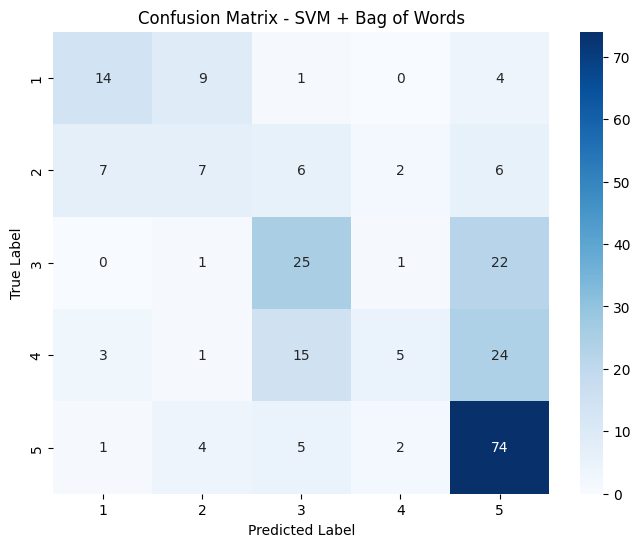

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create a confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot the confusion matrix for the BoW model
plot_confusion_matrix(y_test, y_pred_bow, title="Confusion Matrix - SVM + Bag of Words")

## 4.2 SVM + Embeddings

Uso de `spacy` para converter as avalia√ß√µes em embeddings e treinar o SVM com esses vetores.

In [30]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

import spacy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Usa embeddings do spaCy
nlp = spacy.load("pt_core_news_md")
X_train_embedded = [nlp(text).vector for text in X_train]
X_test_embedded = [nlp(text).vector for text in X_test]

# Normaliza os embeddings
scaler = StandardScaler()
X_train_embedded = scaler.fit_transform(X_train_embedded)
X_test_embedded = scaler.transform(X_test_embedded)

# Treina o SVM com embeddings
svm_embedding = SVC()
svm_embedding.fit(X_train_embedded, y_train)
y_pred_embed = svm_embedding.predict(X_test_embedded)

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.4/42.4 MB 51.8 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
‚ö† Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


### Avalia√ß√£o dos Resultados para o SVM + Embeddings

In [31]:
# Avalia√ß√£o
print("SVM + Embeddings")
print(classification_report(y_test, y_pred_embed))

# Calcula a acur√°cia e F1 score
accuracy_embed = accuracy_score(y_test, y_pred_embed)
f1_embed = f1_score(y_test, y_pred_embed, average='weighted')

print(f"Accuracy: {accuracy_embed}")
print(f"F1-score: {f1_embed}")

SVM + Embeddings
              precision    recall  f1-score   support

           1       0.57      0.57      0.57        28
           2       0.33      0.25      0.29        28
           3       0.51      0.43      0.47        49
           4       0.45      0.10      0.17        48
           5       0.58      0.93      0.71        86

    accuracy                           0.54       239
   macro avg       0.49      0.46      0.44       239
weighted avg       0.51      0.54      0.49       239

Accuracy: 0.5397489539748954
F1-score: 0.48715829002333505


### Matriz de Confus√£o para o SVM + Embedding

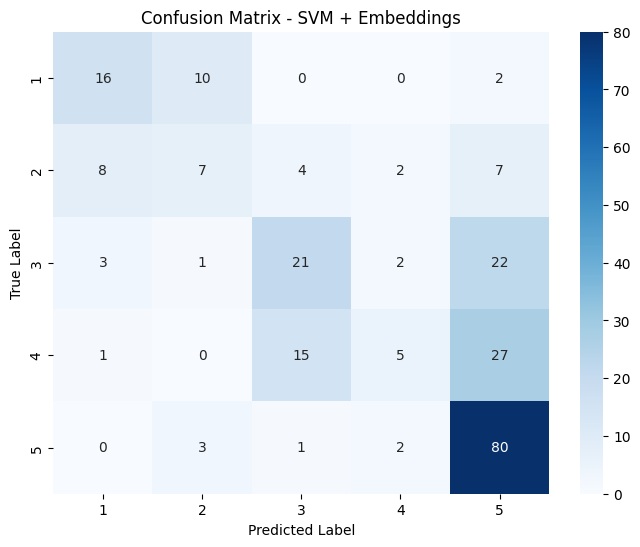

In [34]:
plot_confusion_matrix(y_test, y_pred_embed, title="Confusion Matrix - SVM + Embeddings")

## 4.3 BERT para Classifica√ß√£o

Usando `transformers` para fine-tuning de um modelo BERT para classifica√ß√£o de sentimentos.

In [32]:
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf

# Restringe o TensorFlow para usar apenas a CPU
tf.config.set_visible_devices([], 'GPU')

# Prepara o modelo BERT
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=5)

# Tokeniza os dados
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="tf")
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="tf")

# Define o otimizador e a fun√ß√£o de perda
optimizer = AdamWeightDecay(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

# Loop de treinamento personalizado
def train_step(inputs, targets):
    # Subtrai 1 dos targets para ajustar o intervalo para 0-4
    targets = targets - 1
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions.logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    metrics.update_state(targets, predictions.logits)
    return loss, metrics.result()

# Loop de Treinamento
epochs = 3
batch_size = 8
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        batch_inputs = {k: v[i:i + batch_size] for k, v in X_train_tokens.data.items()}
        batch_targets = y_train[i:i + batch_size]
        # Subtraindo 1 dos targets para ajustar o intervalo para 0-4
        loss, accuracy = train_step(batch_inputs, batch_targets)
        print(f"Batch {i // batch_size + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/3
Batch 1: Loss = 1.5787, Accuracy = 0.3750
Batch 2: Loss = 1.5828, Accuracy = 0.3750
Batch 3: Loss = 1.5149, Accuracy = 0.3750
Batch 4: Loss = 1.3842, Accuracy = 0.4375
Batch 5: Loss = 1.6038, Accuracy = 0.4000
Batch 6: Loss = 1.6119, Accuracy = 0.3750
Batch 7: Loss = 1.8135, Accuracy = 0.3393
Batch 8: Loss = 1.6113, Accuracy = 0.3281
Batch 9: Loss = 1.4714, Accuracy = 0.3333
Batch 10: Loss = 1.7096, Accuracy = 0.3125
Batch 11: Loss = 1.4744, Accuracy = 0.3295
Batch 12: Loss = 1.6325, Accuracy = 0.3125
Batch 13: Loss = 1.4635, Accuracy = 0.3269
Batch 14: Loss = 1.4730, Accuracy = 0.3304
Batch 15: Loss = 1.3663, Accuracy = 0.3500
Batch 16: Loss = 1.4015, Accuracy = 0.3594
Batch 17: Loss = 1.4076, Accuracy = 0.3750
Batch 18: Loss = 1.4436, Accuracy = 0.3819
Batch 19: Loss = 1.6592, Accuracy = 0.3684
Batch 20: Loss = 1.4813, Accuracy = 0.3688
Batch 21: Loss = 1.7629, Accuracy = 0.3571
Batch 22: Loss = 1.5168, Accuracy = 0.3580
Batch 23: Loss = 1.6616, Accuracy = 0.3533
Batch 24: 

### Avalia√ß√£o dos Resultados para o BERT

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Avalia√ß√£o
predictions = model(X_test_tokens.data).logits

# Obt√©m os r√≥tulos previstos a partir dos logits
predicted_labels = np.argmax(predictions, axis=1)

# Ajusta y_test para o intervalo 0-4 para avalia√ß√£o (se necess√°rio)
y_test_adjusted = y_test - 1

# Calcula as m√©tricas
accuracy_bert = accuracy_score(y_test_adjusted, predicted_labels)
f1_bert = f1_score(y_test_adjusted, predicted_labels, average='weighted')
loss = loss_fn(y_test_adjusted, predictions) # Calcula a perda ap√≥s o ajuste do y_test

print("\nBERT:")
print(f"Test Loss: {loss:.4f}") # Imprime a perda
print(f"Acur√°cia: {accuracy_bert:.4f}")
print(f"F1 Score: {f1_bert:.4f}")


BERT:
Test Loss: 1.0770
Acur√°cia: 0.6025
F1 Score: 0.5816


### Matriz de Confus√£o para o Resultado do BERT

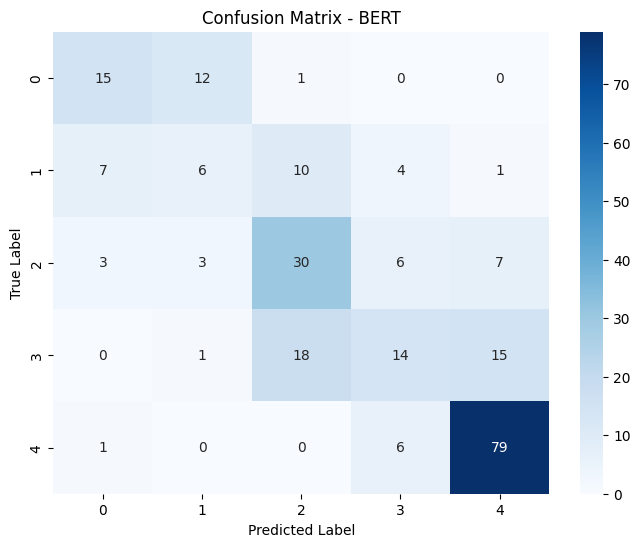

In [36]:
# ### Matriz de Confus√£o para o Resultado do BERT
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the confusion matrix for the BERT model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test_adjusted, predicted_labels, title="Confusion Matrix - BERT")

# 5. Comparativo de M√©tricas e Resultados

Resultado comparativo entre os tr√™s modelos (SVM + BoW, SVM + Embebddings e BERT).

In [37]:
# Cria um dicion√°rio com os resultados
resultados = {
    "Modelo": ["SVM + Bag of Words", "SVM + Embeddings", "BERT"],
    "Acur√°cia": [accuracy_bow, accuracy_embed, accuracy_bert],
    "F1-Score": [f1_bow, f1_embed, f1_bert]
}

# Cria um DataFrame pandas com os resultados
df_resultados = pd.DataFrame(resultados)

# Exibe o DataFrame
print(df_resultados)

               Modelo  Acur√°cia  F1-Score
0  SVM + Bag of Words  0.523013  0.477371
1    SVM + Embeddings  0.539749  0.487158
2                BERT  0.602510  0.581611


### Gr√°fico com Compara√ß√£o de Desempenho dos Modelos

<Figure size 1000x600 with 0 Axes>

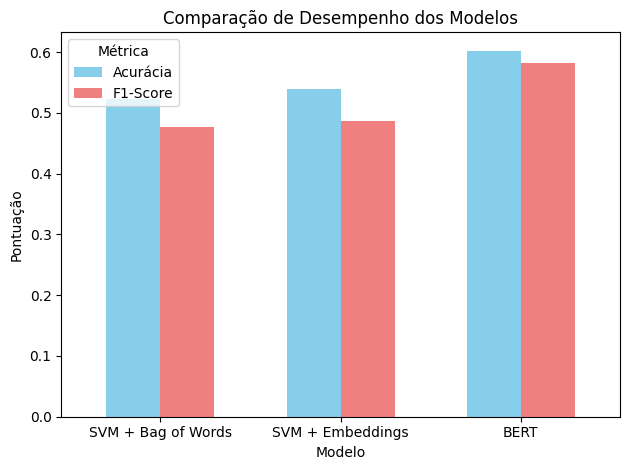

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
df_resultados.plot(x="Modelo", y=["Acur√°cia", "F1-Score"], kind="bar", width=0.6, color=['skyblue', 'lightcoral'])
plt.title("Compara√ß√£o de Desempenho dos Modelos")
plt.ylabel("Pontua√ß√£o")
plt.xticks(rotation=0)
plt.legend(title="M√©trica")
plt.tight_layout()
plt.show()

# 6. Classifica√ß√£o com In-Context Learning (B√¥nus)

Utilizando LLM para realizar a classifica√ß√£o de sentimentos diretamente com poucas instru√ß√µes, sem a necessidade de treinamento expl√≠cito.

In [77]:
# Define o temeplate do prompt
prompt_template = """
Voc√™ √© um assistente de an√°lise de sentimentos. Sua tarefa √© classificar avalia√ß√µes de produtos como "positivo", "negativo" ou "neutro".

Aqui est√° uma avalia√ß√£o de um produto:
{review_text}

Classifique a avalia√ß√£o acima como "Positivo", "Neutro" ou "Negativo". Responda apenas com a classifica√ß√£o, sem adicionar coment√°rios ou explica√ß√µes adicionais.
"""

# Define fun√ß√£o para exibi√ß√£o da classifica√ß√£o
def add_emoji_to_classification(classification):
  if classification == "Positivo":
    return "üòä " + classification
  elif classification == "Neutro":
    return "üòê " + classification
  elif classification == "Negativo":
    return "üòû " + classification
  else:
    return classification

# Define fun√ß√£o para compara√ß√£o com resultado da coluna "sentiment"
def compare_classification_with_actual(classification, actual_sentiment):
  is_correct = classification.lower() == actual_sentiment.lower()
  result = "‚úÖ Correto" if is_correct else "‚ùå Incorreto"
  return result, is_correct

## 6.1 Using OpenAI (GPT-4)

In [80]:
from google.colab import userdata
from openai import OpenAI

# Retorna a chave de API da OpenAI API do userdata
api_key = userdata.get('OPENAI_API_KEY')

# Inicializa o cliente da OpenAI
client = OpenAI(api_key=api_key)

def classify_with_openai(review_text):
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "user", "content": prompt_template.format(review_text=review_text)}
        ]
    )
    return completion.choices[0].message.content.strip()

# Classifica 10 reviews aleat√≥rias
random_reviews = df.sample(n=10)

print("Classifica√ß√£o da OpenAI GPT-4")
print("=" * 90)

for index, row in random_reviews.iterrows():
    review_text = row['review']
    classification = classify_with_openai(review_text)

    # Add emoji
    display_classification = add_emoji_to_classification(classification)

    # Compara o resultado com o sentimento correto
    result, is_correct = compare_classification_with_actual(classification, row['sentiment'])

    print(f"\nAvalia√ß√£o: {review_text}")
    print(f"Classifica√ß√£o da OpenAI: {display_classification}")
    print("-" * 90)
    print(f"Sentimento Real: {row['sentiment'].capitalize()}")
    print(f"Resultado: {result}")

Classifica√ß√£o da OpenAI GPT-4


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## 6.2 Using Google Gemini 1.5

In [81]:
from google.colab import userdata
import google.generativeai as genai

# Retorna a chave de API do Google Gemini do userdata
myKey = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=myKey)

# Espcifica o modelo do Gemini
model = genai.GenerativeModel("gemini-1.5-flash-latest")

def classify_with_gemini(review_text):
    response = model.generate_content(prompt_template.format(review_text=review_text))
    classification = response.text.strip()
    return classification

# Classifica 10 reviews aleat√≥rias
random_reviews = df.sample(n=10)

print("Classifica√ß√£o do Google Gemini 1.5")
print("=" * 90)

for index, row in random_reviews.iterrows():
    review_text = row['review']
    classification = classify_with_gemini(review_text)

    # Adiciona o emoji
    display_classification = add_emoji_to_classification(classification)

    # Compara o resultado com o sentimento correto
    result, is_correct = compare_classification_with_actual(classification, row['sentiment'])

    print(f"\nAvalia√ß√£o: {review_text}")
    print(f"Classifica√ß√£o do Gemini: {display_classification}")
    print("-" * 90)
    print(f"Sentimento Real: {row['sentiment'].capitalize()}")
    print(f"Resultado: {result}")

Classifica√ß√£o do Google Gemini 1.5

Avalia√ß√£o: Produto √≥timo, adorei!
Classifica√ß√£o do Gemini: üòä Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ‚úÖ Correto

Avalia√ß√£o: O bot√£o lateral √© um pouco duro, dif√≠cil de apertar.
Classifica√ß√£o do Gemini: üòû Negativo
------------------------------------------------------------------------------------------
Sentimento Real: Neutro
Resultado: ‚ùå Incorreto

Avalia√ß√£o: Material parece de boa qualidade, mas ainda vou testar mais.
Classifica√ß√£o do Gemini: üòê Neutro
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ‚ùå Incorreto

Avalia√ß√£o: Os atalhos do sistema facilitam muito o uso no dia a dia.
Classifica√ß√£o do Gemini: üòä Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resulta